<a href="https://colab.research.google.com/github/nagamamo/international_finance/blob/main/6_2_asset_approach_by_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Appendix 2  為替レート決定理論×機械学習**

　本例では、アセット・アプローチの理論実装例を示します。ここで示されるのは厳密には、マネタリー・アプローチ・モデルです。まず汎用ライブラリとして、pandas、numpy、datetime、matplotlibを読み込みます。

In [1]:
#[1]汎用ライブラリの読み込み
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
#[2]機械学習用ライブラリの読み込み
from sklearn.model_selection import train_test_split #Library for splitting data into training data and test data
from sklearn.linear_model import Lasso #Library for ML(Lasso)
from sklearn.linear_model import LassoCV #Libraries for cross-validation
from sklearn.model_selection import GridSearchCV #Library for hyperparameter (L1 penalty) search

　外国為替レート、日米消費者物価指数、日米10年債金利の1990年1月から2025年11月までのデータを取得します。本データの場合は、日時情報”Date”はデータとして利用しませんので、datetimeへ変換してインデックスとして利用します。これによりグラフ作成の際に横軸目盛が自動調整され、目盛文字が重なることがありません。

In [4]:
#[3]データの取得：URLから読み込む場合
url = "https://github.com/nagamamo/data/blob/main/9_2_fx_market_data.csv?raw=true"#Git-hubからCSVデータの入手
data = pd.read_csv(url)#データフレームの作成
data["Date"] = pd.to_datetime(data["Date"]) #日時をインデックスの変換のためdatetimeへ変換
US_Japan = data.set_index("Date")#日時をインデックスへ変換

In [ ]:
#[3]データの取得:CSVファイルを読み込む場合
import csv #データ読込みのためのライブラリのインポート
from google.colab import files
uploaded = files.upload() #データアップロードの指示
import io #データ形式指定のライブラリのインポート
df = pd.read_csv(io.BytesIO(uploaded['9_2_fx_market_data.csv']), encoding='shift_jis') #データ読込みの指示
df["Date"] = pd.to_datetime(df["Date"]) #日時をインデックスの変換のためdatetimeへ変換
US_Japan = df.set_index("Date")#日時をインデックスへ変換
US_Japan.head() #データ概要の表示

　取得したデータから、ドル円レートの前月比（d_Yen）、日米インフレ率格差（d_P）、日米10年債金利スプレッド(d_R)を算出してpandasデータフレームにそれぞれの新変数列を追加します。この2つの説明変数が、購買力平価要因とマネタリー・アプローチ要因を説明します。重ねて述べるように、sklearnではデータの入出力はnumpy配列を前提としていますので、pandasデータフレームのデータを「.value」により変換し、これをYとXとします。

In [5]:
#[4]採用変数の算出と定義
US_Japan['d_R']=US_Japan['10USB']-US_Japan['10JPB'] #日米長期金利差の算出
US_Japan['d_P']=US_Japan['P_US']-US_Japan['P_JP'] #日米インフレ率格差の算出
US_Japan['d_Yen']=US_Japan['Yen'].pct_change()*100 #為替レート前月比の算出
US_Japan=US_Japan.dropna()#欠損値の除去
Y=US_Japan['d_Yen'].values #被説明変数の定義と配列変更
X=US_Japan[['d_R','d_P']].values #説明変数の定義と配列変更

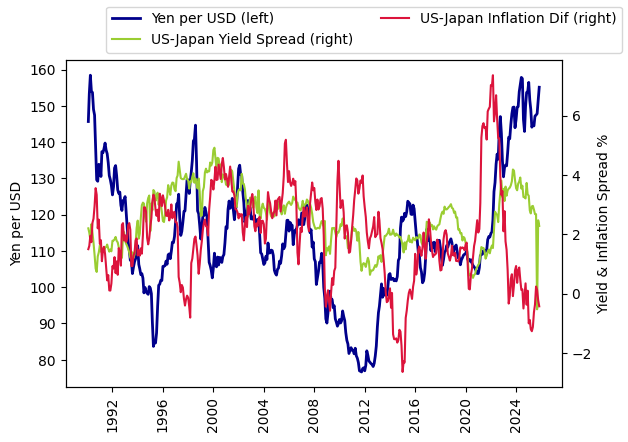

In [6]:
#[5]データの可視化
fig = plt.figure()
ax1 = fig.subplots()
ax2 = ax1.twinx()
ax1.plot(US_Japan['Yen'], lw=2, color="darkblue",label="Yen per USD (left)")
ax2.plot(US_Japan['d_R'], c="yellowgreen",label="US-Japan Yield Spread (right)")
ax2.plot(US_Japan['d_P'], c="crimson",label="US-Japan Inflation Dif (right)")
fig.autofmt_xdate(rotation=90, ha="center")
plt.ylabel('Yen per USD')
ax1.set_ylabel('Yen per USD')
ax2.set_ylabel('Yield & Inflation Spread %')
fig.legend(ncol=2)
plt.show()

In [ ]:
#[6]ハイパーパラメターの推計
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)#Splitting training data and test data
param_grid = {'alpha': [0.1, 1.0, 10.0]} #Setting initial values
grid_search = GridSearchCV(Lasso(), param_grid, cv=5) #Setting initial values ​​for cross-evaluation
grid_search.fit(X_train, Y_train) #Running a search
optimal_alpha = grid_search.best_params_['alpha']
print(f"Optimal Alpha: {optimal_alpha}") #Visualization of search results

In [ ]:
#[7]Lasso回帰によるドル円モデルの推計
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=0)#Splitting training data and test data
machine = Lasso(alpha=0.1)#Definition of ML estimation method
machine.fit(X_train,Y_train)#Fitting
Y_train_pred=machine.predict(X_train)#Predictions using training data
Y_test_pred=machine.predict(X_test)#Predictions using test data
#print('β =  %.4f'% machine.coef_[0])
print(f"Coef: {machine.coef_:}")
print(f"Intercept: {machine.intercept_:}")
print(f"R_squared: {machine.score(X_test, Y_test):.6f}")

In [ ]:
#[8]Lasso回帰結果を用いたドル円レートの予測
lastR=US_Japan.d_R[-1] #標本データ直近の米日金利差
lastP=US_Japan.d_P[-1] #標本データ直近の米日インフレ率格差
add_spread=1.0 #金利スプレッド拡大幅
add_CPI=0.0 #インフレ率格差拡大幅
spot=153.54 #直近ドル円レート
senario_R=lastR+add_spread
senario_P=lastP+add_CPI
a=machine.predict([[senario_P,senario_R]])
spot*(1+a/100)
